# **Environment Setting**

In [1]:
# Install if necessary
!pip install ucimlrepo

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns
from ucimlrepo import fetch_ucirepo
from scipy.stats import chi2_contingency

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.metrics import matthews_corrcoef, make_scorer

pd.set_option('display.max_columns', 500)

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/playground-series-s4e8/sample_submission.csv
/kaggle/input/playground-series-s4e8/train.csv
/kaggle/input/playground-series-s4e8/test.csv


In [3]:
# Notebook Parameters
import_sample_data = True # change this when necessary
sample_data_size = 0.5
random_state = 42
nulls_limit = 0.80

In [4]:
# Import Data
original = fetch_ucirepo(id=848).data.original
train = pd.read_csv('/kaggle/input/playground-series-s4e8/train.csv', index_col='id')
if import_sample_data:
    train = train.sample(frac=sample_data_size, random_state=random_state)
test = pd.read_csv('/kaggle/input/playground-series-s4e8/test.csv', index_col='id')

print('Original shape:', original.shape)
print('Train shape:', train.shape)
print('Test shape:', test.shape)

Original shape: (61069, 21)
Train shape: (1558472, 21)
Test shape: (2077964, 20)


# **Feature Engineering**

In [5]:
# Create target variable
train['edible'] = np.where(train['class'] == 'e', 1, 0)
train.sample(5, random_state=random_state)

,class,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,stem-height,stem-width,stem-root,stem-surface,stem-color,veil-type,veil-color,has-ring,ring-type,spore-print-color,habitat,season,edible
id,,,,,,,,,,,,,,,,,,,,,,
483440,e,10.33,x,s,n,f,e,c,w,9.01,10.75,NaN,i,w,NaN,NaN,f,f,p,d,u,1
257308,p,4.91,f,k,n,f,p,NaN,n,3.90,5.77,NaN,k,n,NaN,NaN,t,f,NaN,d,u,0
880269,p,3.60,x,i,e,f,NaN,NaN,e,4.69,6.28,NaN,NaN,e,NaN,NaN,f,f,n,d,a,0
85140,p,11.11,x,t,n,t,d,c,n,4.92,14.25,NaN,NaN,n,NaN,NaN,f,f,NaN,d,a,0
165744,p,3.57,x,NaN,n,f,a,NaN,k,9.96,2.73,NaN,NaN,n,NaN,w,f,f,k,g,a,0


As the train and test data come from an original data published on UC Irvine Machine Learning Repository, first we will limit only those values of the categorical features that are also present on the original data.  

For example, consider cap-shape: 

In [6]:
# Train data
train['cap-shape'].value_counts(dropna=False)

cap-shape
x            718515
f            337840
s            182310
b            159243
o             54201
p             53710
c             52390
d                32
e                25
n                22
NaN              22
w                20
t                17
g                15
a                13
u                13
y                13
r                11
z                 9
k                 8
l                 7
i                 6
h                 5
20.25             1
3.37              1
3.52              1
7.43              1
4.97              1
6 x               1
4.33              1
2.82              1
9.13              1
54.78             1
21.56             1
49.21             1
is p              1
is s              1
24.16             1
7 x               1
8.3               1
ring-type         1
b f               1
19.06             1
5.15              1
6.44              1
7.21              1
4.22              1
3.91              1
Name: count, dtype: int64

In [7]:
# Original data
original['cap-shape'].value_counts(dropna=False)

cap-shape
x    26934
f    13404
s     7164
b     5694
o     3460
p     2598
c     1815
Name: count, dtype: int64

We see that on the original data, cap-shape is supposed to have only a few letters as categories. However, on the train data there are some values that should not be there. Because of this we will drop all those values that do not match with the original dataset, in order to cast them correctly as categories.

In [8]:
# Isolate categorical columns
train_numerical_features = train.select_dtypes(include=[float, int]).columns
train_cat_features = train.columns.difference(train_numerical_features)

# Cast categorical columns to category type
for c in train_cat_features:
    possible_values = set(original[c].unique())
    train.loc[~train[c].isin(possible_values), c] = np.nan
    train[c] = train[c].astype('category')
    if c != 'class':
        test.loc[~test[c].isin(possible_values), c] = np.nan
        test[c] = test[c].astype('category')

Now we have only allowed values, an the rest are missing. Before moving one, we will evaluate the percentage of missing values, to determine if they need to be dropped later.

In [9]:
def percentage_missings(df):
    df_nulls = df.isnull().sum().reset_index(drop=False)
    df_nulls = df_nulls.rename(columns={'index': 'column', 0: 'n_missings'})
    df_nulls['p_nulls'] = (df_nulls['n_missings'] / df.shape[0]).round(2)
    df_nulls = df_nulls.sort_values('p_nulls', ascending=False)
    return df_nulls

In [10]:
train_nulls = percentage_missings(train)
train_nulls.head()

,column,n_missings,p_nulls
14,veil-type,1478640,0.95
18,spore-print-color,1425200,0.91
11,stem-root,1378377,0.88
15,veil-color,1370615,0.88
12,stem-surface,990618,0.64


In [11]:
test_nulls = percentage_missings(test)
test_nulls.head()

,column,n_missings,p_nulls
13,veil-type,1971591,0.95
17,spore-print-color,1899728,0.91
10,stem-root,1838125,0.88
14,veil-color,1826228,0.88
11,stem-surface,1321738,0.64


By following this method, we end up with 4 features that have a high percentage of missing values, with rates exceeding 85%. This is the threshold we will follow to determine the columns to drop.

In [12]:
train = train.drop(columns=train_nulls.loc[train_nulls['p_nulls'] > nulls_limit, 'column'])
test = test.drop(columns=test_nulls.loc[test_nulls['p_nulls'] > nulls_limit, 'column'])

The other columns will follow an imputation. In this case, we will use the mode.

In [13]:
def impute_missings(df, num_method='mean', cat_method='most_frequent'):
    numerical_features = df.select_dtypes(include=[float, int]).columns
    categorical_features = df.select_dtypes(include=['category', 'object']).columns
    
    num_imputer = SimpleImputer(strategy=num_method)
    df_num_imputed = pd.DataFrame(num_imputer.fit_transform(df[numerical_features]), columns=numerical_features)

    cat_imputer = SimpleImputer(strategy=cat_method)
    df_cat_imputed = pd.DataFrame(cat_imputer.fit_transform(df[categorical_features]), columns=categorical_features)

    df_imputed = pd.concat([df_num_imputed, df_cat_imputed], axis=1)

    for c in df_imputed.columns:
        if c in numerical_features:
            df_imputed[c] = df_imputed[c].astype(int)
        else:
            df_imputed[c] = df_imputed[c].astype('category')

    return df_imputed

train_imputed = impute_missings(train)
test_imputed = impute_missings(test)

In [14]:
train_imputed.dtypes

cap-diameter               int64
stem-height                int64
stem-width                 int64
edible                     int64
class                   category
cap-shape               category
cap-surface             category
cap-color               category
does-bruise-or-bleed    category
gill-attachment         category
gill-spacing            category
gill-color              category
stem-surface            category
stem-color              category
has-ring                category
ring-type               category
habitat                 category
season                  category
dtype: object

# **Features Distribution**

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

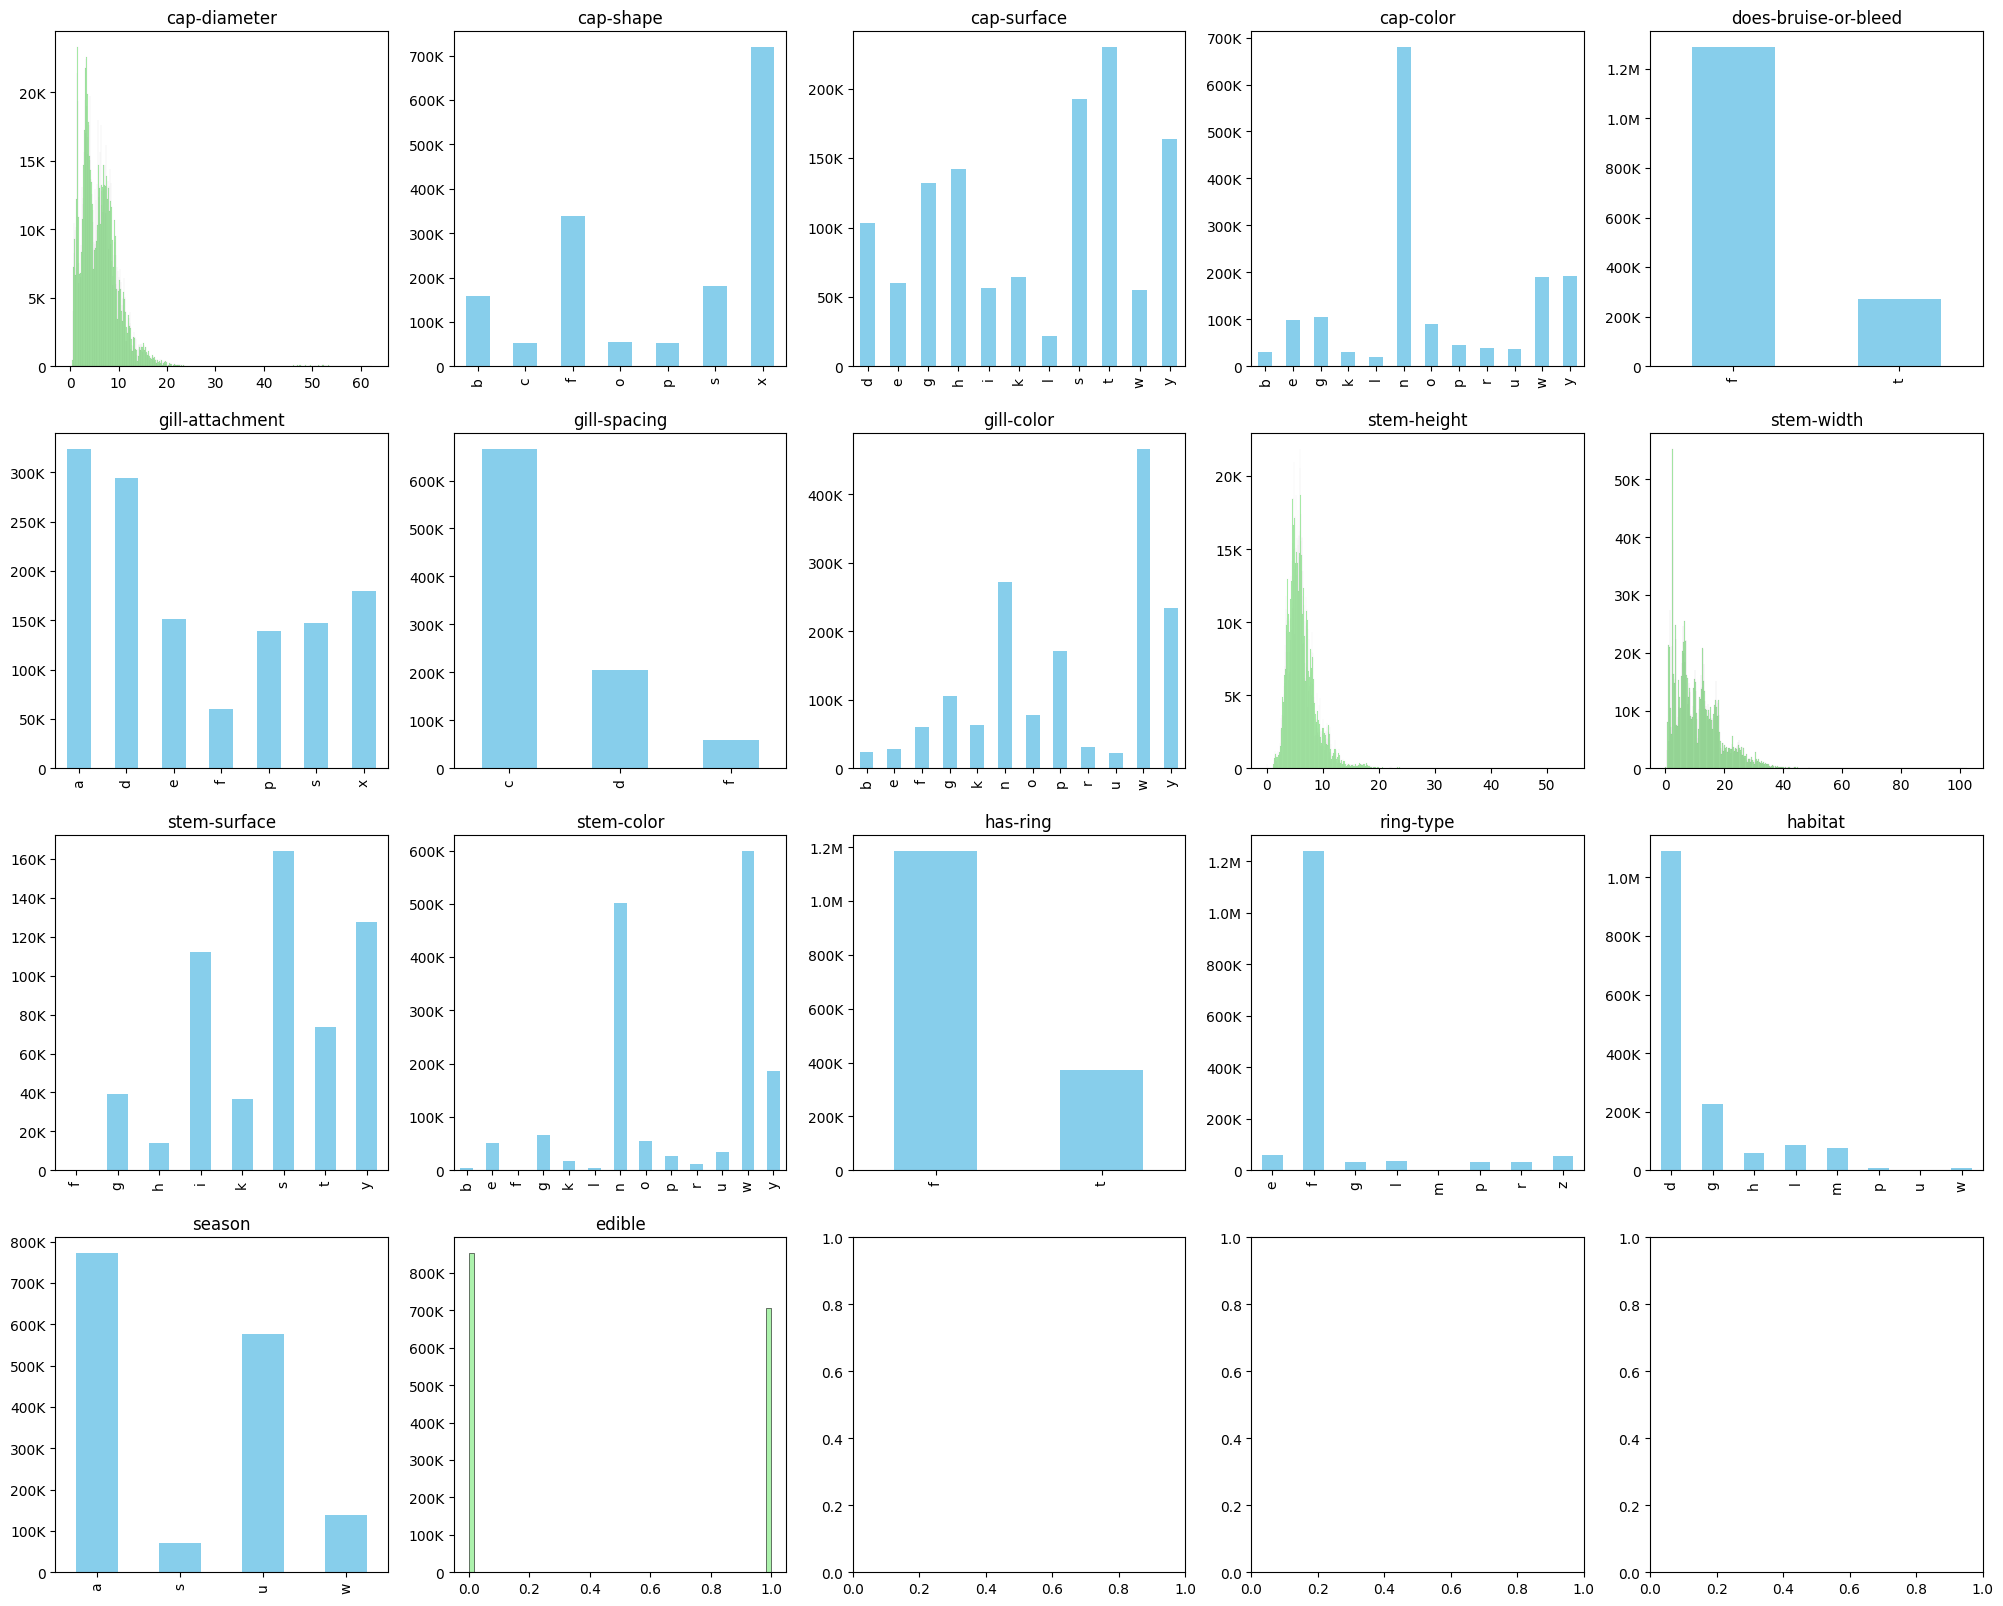

In [15]:
def thousands_formatter(x, pos):
    if x >= 1e6:
        return f'{x*1e-6:.1f}M'
    elif x >= 1e3:
        return f'{x*1e-3:.0f}K'
    else:
        return f'{x:.0f}'

def plot_feature_distribution(df: pd.DataFrame):
    fig, axs = plt.subplots(4, 5, figsize=(20, 16))
    plt.tight_layout()
    df = df.drop(columns='class')

    for c, ax in zip(df.columns, axs.flatten()):
        if pd.api.types.is_numeric_dtype(df[c]):
            sns.histplot(df[c], ax=ax, color='lightgreen')
        else:
            df[c].value_counts(sort=False).plot(kind='bar', ax=ax, color='skyblue')
        ax.set_xlabel('')
        ax.set_ylabel('')
        ax.set_title(f"{c}", fontsize=12)
        ax.yaxis.set_major_formatter(FuncFormatter(thousands_formatter))
    
    fig.subplots_adjust(wspace=0.2, hspace=0.2)
    plt.show()

plot_feature_distribution(train)

These distributions are interesting to know. The ones that stand out are the histograms of the features with float values. In fact the three of them are right-skewed, so most of the values are on the lower side of the distribution.

# **Features Relationships**

Additionaly, we will evaluate the relationships between the features and the target variable. For this, we will use chi-square tests for the categorical variables and pearson correlation for numerical variables.

In [16]:
# Chi-squared results for categorical features
chi2_results = {}
cat_features = train_imputed.select_dtypes(include='category').columns
for cat in cat_features:
    contingency_table = pd.crosstab(train_imputed['edible'], train_imputed[cat], margins=True)
    p = chi2_contingency(contingency_table).pvalue
    chi2_results[cat] = p

chi2_results_table = pd.Series(chi2_results).reset_index(drop=False)
chi2_results_table = chi2_results_table.rename(columns={'index': 'column', 0: 'p_value'})
chi2_results_table = chi2_results_table.sort_values(by='p_value', ascending=False).reset_index(drop=True)
chi2_results_table['p_value'] = chi2_results_table['p_value'].round(4)
chi2_results_table

,column,p_value
0,class,0.0
1,cap-shape,0.0
2,cap-surface,0.0
3,cap-color,0.0
4,does-bruise-or-bleed,0.0
5,gill-attachment,0.0
6,gill-spacing,0.0
7,gill-color,0.0
8,stem-surface,0.0
9,stem-color,0.0


In [17]:
# Pearson correlation for numerical features
pearson_corr = train[train_numerical_features].corr()
pearson_corr

,cap-diameter,stem-height,stem-width,edible
cap-diameter,1.000000,0.363922,0.746614,0.162214
stem-height,0.363922,1.000000,0.356400,0.049454
stem-width,0.746614,0.356400,1.000000,0.169382
edible,0.162214,0.049454,0.169382,1.000000


# **Models**

We need to prepare input data. Because we already have a test data but without a target, we will use this to predict the final classification. Before that, we need to split the data into train and test.

In [18]:
X_train = train_imputed.drop(columns=['edible', 'class']).copy()
y_train = train_imputed['edible']
X_test = test_imputed.copy()

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=random_state)

We will create a pipeline to transform columns. Numerical features need to be scaled and categorical features need to be encoded into dummies.

In [19]:
def transform_columns(df):
    num_features = df.select_dtypes(include=[int, float]).columns
    cat_features = df.columns.difference(num_features)

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), num_features),
            ('cat', OneHotEncoder(drop='first'), cat_features)
        ]
    )

    pipeline = Pipeline(steps=[('preprocessor', preprocessor)])
    df_densed = pipeline.fit_transform(df).toarray()
    
    cat_feature_names = pipeline.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out()
    all_feature_names = list(X_train.select_dtypes(include=[int, float]).columns) + list(cat_feature_names)

    df_transformed = pd.DataFrame(df_densed, columns=all_feature_names)

    return df_transformed

In [20]:
# Input data for training models
X_train_transformed = transform_columns(X_train)
X_val_transformed = transform_columns(X_val)
X_test_transformed = transform_columns(X_test)

In [21]:
# Logistic Regression
logreg = LogisticRegression(random_state=random_state, max_iter=1000, n_jobs=-1)
logreg.fit(X_train_transformed, y_train)
y_val_pred = logreg.predict(X_val_transformed)

mcc = matthews_corrcoef(y_val, y_val_pred)
print(f'Matthews Correlation Coefficient (MCC) with Logistic Regression: {mcc:.4f}')

Matthews Correlation Coefficient (MCC) with Logistic Regression: 0.6108


In [22]:
# K-Nearest Neighbors
knn = KNeighborsClassifier(n_jobs=-1)
knn.fit(X_train_transformed, y_train)
y_val_pred = knn.predict(X_val_transformed)

mcc = matthews_corrcoef(y_val, y_val_pred)
print(f'Matthews Correlation Coefficient (MCC) with K-Nearest Neighbors: {mcc:.4f}')

Matthews Correlation Coefficient (MCC) with K-Nearest Neighbors: 0.9808


In [23]:
# Random Forest
rf = RandomForestClassifier(random_state=random_state, n_estimators=200, n_jobs=-1)
rf.fit(X_train_transformed, y_train)
y_val_pred = rf.predict(X_val_transformed)

mcc = matthews_corrcoef(y_val, y_val_pred)
print(f'Matthews Correlation Coefficient (MCC) with Random Forest: {mcc:.4f}')

Matthews Correlation Coefficient (MCC) with Random Forest: 0.9812


In [24]:
# XGBoost + GridSearchCV
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5],
    'learning_rate': [0.1]
}

kf = KFold(n_splits=5, shuffle=True, random_state=random_state)

xgb = XGBClassifier(
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=random_state,
    n_jobs=-1
)

grid_search_xgb = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    cv=kf,
    scoring=make_scorer(matthews_corrcoef),
    verbose=True,
)
grid_search_xgb.fit(X_train_transformed, y_train)

print('Best XGBoost parameters:', grid_search_xgb.best_params_)

best_xgb = grid_search_xgb.best_estimator_
best_xgb.fit(X_train_transformed, y_train)
y_val_pred = best_xgb.predict(X_val_transformed)

mcc = matthews_corrcoef(y_val, y_val_pred)
print(f'Matthews Correlation Coefficient (MCC) with XGBoost: {mcc:.4f}')

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best XGBoost parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200}
Matthews Correlation Coefficient (MCC) with XGBoost: 0.9558


# **Final Prediction**

So far, the best model is the Random Forest with 200 estimators. Now we will predict the labels and format the final submission in csv.

In [25]:
y_test_pred = rf.predict(X_test_transformed)
y_test_pred_class = np.where(y_test_pred == 1, 'e', 'p')
print(len(y_test_pred))
print(len(test))

2077964
2077964


In [26]:
submission = pd.DataFrame({'id': test.index, 'class': y_test_pred_class})
submission.head()

,id,class
0,3116945,e
1,3116946,p
2,3116947,p
3,3116948,p
4,3116949,e


In [27]:
submission.to_csv('submission.csv', index=False)